<h1> Predictions of LOTR characters based on script quotes  </h1>
<br>
<h2> PROJECT DESCRIPTION </h2>
<p> --------------------- </p>
<br>
<h2>1.  Import libraries and download dataset </h2>

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split as TTS,  GridSearchCV  
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as NB


import nltk
from nltk.corpus import stopwords, sentiwordnet, wordnet
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import spacy

from typing import List
from pprint import pprint


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim

import tqdm

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

stopwords_set = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [156]:
lotr = pd.read_csv("data/lotr_scripts.csv")

<h2> 2. Preprocessing 

In [157]:
# Spotting inconcistencies with naming
lotr.char.unique()

array(['DEAGOL', 'SMEAGOL', '(GOLLUM', 'FRODO', 'MERRY', 'GIMLI',
       'GOLLUM', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE',
       'BILBO', 'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIL', 'ELROND',
       'GRIMA', 'FRODO VOICE OVER', 'WITCH KING', 'EOWYN', 'FARAMIR',
       'ORC', '\xa0GANDALF', 'SOLDIERS ON GATE', 'GOTHMOG', 'GENERAL',
       'CAPTAIN', 'SOLDIER', 'MOUTH OF SAURON', 'EOMER', 'ARMY', 'BOSON',
       'MERCENARY', 'EOWYN/MERRY', 'DENETHOR', 'ROHIRRIM',
       'GALADRIEL VOICEOVER', 'LEGOLAS', 'GALADRIEL', 'KING OF THE DEAD',
       'GRIMBOLD', 'IROLAS', 'ORCS', 'GAMLING', 'MADRIL', 'DAMROD',
       'SOLDIERS', 'SOLDIERS IN MINAS TIRITH', 'GANDALF VOICEOVER',
       'SOLDIER 1', 'SOLDIER 2', 'WOMAN', 'HALDIR', 'SAM VOICEOVER',
       'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'ELROND VOICEOVER',
       'ARWEN VOICEOVER', 'ARAGORN ', 'HAMA', 'SHARKU', 'PEOPLE', 'LADY',
       'FREDA', 'MORWEN', 'EYE OF SAURON', 'ROHAN STABLEMAN', 'GORBAG',
       'ARGORN', 'GA

In [158]:
flaws = list(["(GOLLUM", "GALADRIL", "FRODO VOICE OVER", "\xa0GANDALF", "MOUTH OF SAURON", "GALADRIEL VOICEOVER", "GANDALF VOICEOVER", 
         "SAM VOICEOVER", "ELROND VOICEOVER", "ARWEN VOICEOVER", "ARAGORN ", "ARGORN", "GANDALF VOICE OVER", "SARUMAN VOICE OVER", 
         "SARUMAN VOICE OVER ", "URUK-HAI" "FRODO ", "GALADRIEL VOICE-OVER", "SAURON VOICE", "SAM ", "FRODO VOICE", 
         "GALADRIEL VOICE OVER", "SARUMAN VOICEOVER", "BILBO VOICEOVER", "GATEKEEPR", "GAN DALF"])

correct = list(["GOLLUM", "GALADRIEL", "FRODO", "GANDALF","SAURON", "GALADRIEL", "GANDALF", "SAM", "ELROND", "ARWEN", "ARAGORN", "ARAGORN", 
                "GANDALF", "SARUMAN", "SARUMAN", "URUK HAI", "FRODO", "GALADRIEL", "SAURON", "SAM", "FRODO", "GALADRIEL", "SARUMAN", 
                "BILBO", "GATEKEEPER", "GANDALF"])

for i in range(len(flaws)):
    lotr.loc[lotr["char"] == flaws[i], "char"] = correct[i]
lotr.char.unique()


array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

In [159]:
lotr = lotr.dropna(axis=0)
lotr = lotr.drop(["Unnamed: 0", "movie"], axis=1)

<h2>  3. Exploratory data analysis </h2>
<h3> 3.1 Descriptive data analysis </h3>

In [160]:
lotr

,char,dialog
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag..."
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!"
2,DEAGOL,Arrghh!
3,SMEAGOL,Deagol!
4,SMEAGOL,Deagol!
...,...,...
2385,PIPPIN,Merry!
2386,ARAGORN,Merry!
2387,MERRY,He's always followed me everywhere I went sinc...
2388,ARAGORN,One thing I've learnt about Hobbits: They are ...


In [161]:
print('Shape of df:', lotr.shape)
print('Size of df:', lotr.size)

Shape of df: (2389, 2)
Size of df: 4778


In [162]:
lotr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2389 entries, 0 to 2389
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   char    2389 non-null   object
 1   dialog  2389 non-null   object
dtypes: object(2)
memory usage: 56.0+ KB


In [163]:
# Spotting inconcistencies with naming
lotr.char.unique()

array(['DEAGOL', 'SMEAGOL', 'GOLLUM', 'FRODO', 'MERRY', 'GIMLI', 'SAM',
       'GANDALF', 'ARAGORN', 'PIPPIN', 'HOBBIT', 'ROSIE', 'BILBO',
       'TREEBEARD', 'SARUMAN', 'THEODEN', 'GALADRIEL', 'ELROND', 'GRIMA',
       'WITCH KING', 'EOWYN', 'FARAMIR', 'ORC', 'SOLDIERS ON GATE',
       'GOTHMOG', 'GENERAL', 'CAPTAIN', 'SOLDIER', 'SAURON', 'EOMER',
       'ARMY', 'BOSON', 'MERCENARY', 'EOWYN/MERRY', 'DENETHOR',
       'ROHIRRIM', 'LEGOLAS', 'KING OF THE DEAD', 'GRIMBOLD', 'IROLAS',
       'ORCS', 'GAMLING', 'MADRIL', 'DAMROD', 'SOLDIERS',
       'SOLDIERS IN MINAS TIRITH', 'SOLDIER 1', 'SOLDIER 2', 'WOMAN',
       'HALDIR', 'OLD MAN', 'BOROMIR', 'CROWD', 'ARWEN', 'HAMA', 'SHARKU',
       'PEOPLE', 'LADY', 'FREDA', 'MORWEN', 'EYE OF SAURON',
       'ROHAN STABLEMAN', 'GORBAG', 'BOROMIR ', 'UGLUK', 'SHAGRAT',
       'FRODO ', 'URUK-HAI', 'SNAGA', 'GRISHNAKH', 'MERRY and PIPPIN',
       'WILDMAN', 'STRIDER', 'EOTHAIN', 'ROHAN HORSEMAN', 'FARMER MAGGOT',
       'WHITE WIZARD', 'MERRY AND P

<h3> 3.2 Train test split </h3>

In [164]:
train, test = TTS(lotr, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

<h3> 3.3 Data visualization </h3>
<h4> 3.3.1 Dialogue  Frequency </h4>

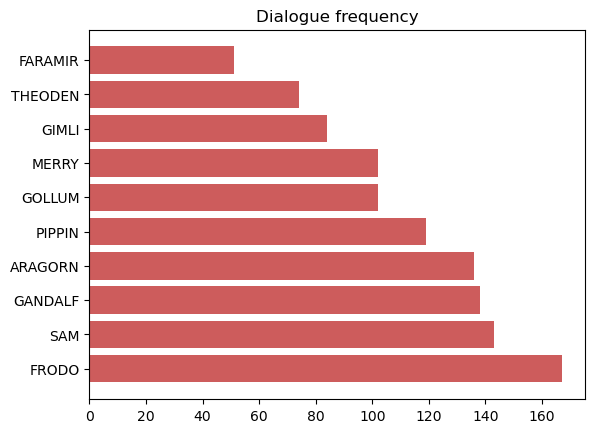

In [165]:
# Plotting dialouge frequnecy
char_freq = train.groupby("char").size().reset_index(name="freq")
char_freq = char_freq.sort_values(by="freq",ascending=False)
plt.barh(char_freq.char[:10], char_freq.freq[:10], color="indianred")
plt.title("Dialogue frequency")
plt.show()


<h2> 4. Feature engineering </h2>
Since the only data that shall be used is a single column with one quote; the exploratory data anlysis will be performed simultanously with the feature engineering part
<br>
<h3> 4.1.1 Count POS </h3>

In [166]:
def simple_features(data: pd.DataFrame):
    # dialog lengths
    data["word_len"] = data.dialog.apply(lambda x: len(x.split()))
    data["character_len"] = data.dialog.apply(lambda x: len(x))
    # Stopword count
    data["stopword_count"] = data.dialog.apply(lambda x: sum(1 for word in x.split() if word.lower() in stopwords_set))
    # Word frequency by POS Tag
    data['verb_count'] = data['dialog'].apply(count_verbs)
    data['adj_count'] = data['dialog'].apply(count_adjectives)
    data['propn_count'] = data['dialog'].apply(count_proper_noun)
    # Uniqe word counter
    data['uinque_words'] = data['dialog'].apply(unique_words)

    return data

def count_verbs(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "VERB")

def count_adjectives(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "ADJ")

def count_proper_noun(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.pos_ == "PROPN")

def unique_words(text):
    return len(set(text.split()))

train = simple_features(train)
test = simple_features(test)

<h3> 4.1.2 Plot POS frequency

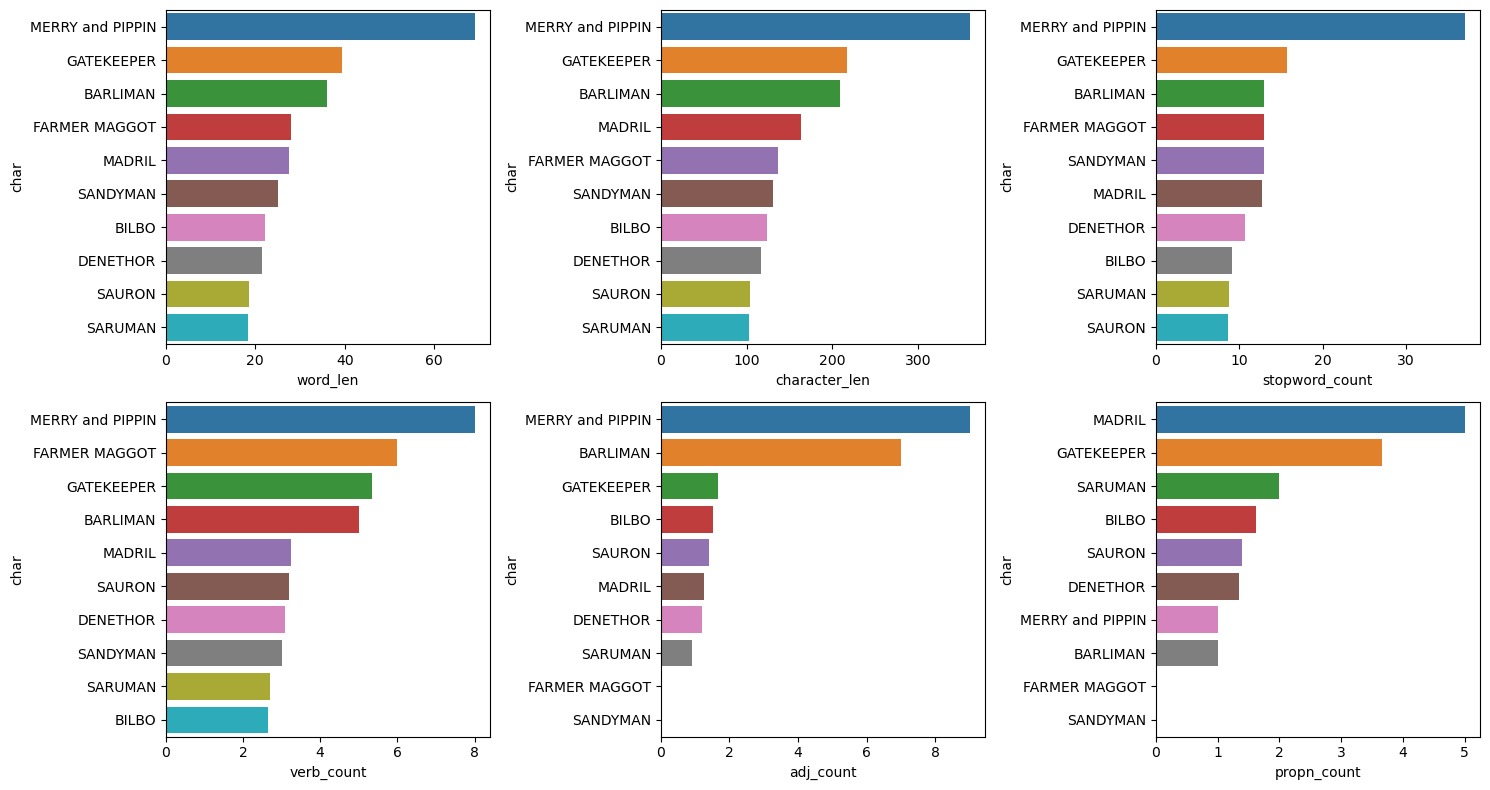

In [167]:
# Plotting dialouge frequnecy
char_var = train.groupby("char")[["word_len", "character_len", "stopword_count", "verb_count", "adj_count", "propn_count"]].mean().reset_index()
#char_var = char_var.sort_values(by="freq",ascending=False)

plt.figure(figsize = (15, 8))
plt.tight_layout()
plt.subplot(2, 3, 1)
char_var = char_var.sort_values(by="word_len", ascending=False)[:10]
sns.barplot(x=char_var.word_len, y=char_var.char)
plt.subplot(2, 3, 2)
char_var = char_var.sort_values(by="character_len", ascending=False)[:10]
sns.barplot(x=char_var.character_len, y=char_var.char)
plt.subplot(2, 3, 3)
char_var = char_var.sort_values(by="stopword_count", ascending=False)[:10]
sns.barplot(x=char_var.stopword_count, y=char_var.char)
plt.subplot(2, 3, 4)
char_var = char_var.sort_values(by="verb_count", ascending=False)[:10]
sns.barplot(x=char_var.verb_count, y=char_var.char)
plt.subplot(2, 3, 5)
char_var = char_var.sort_values(by="adj_count", ascending=False)[:10]
sns.barplot(x=char_var.adj_count, y=char_var.char)
plt.subplot(2, 3, 6)
char_var = char_var.sort_values(by="propn_count", ascending=False)[:10]
sns.barplot(x=char_var.propn_count, y=char_var.char)
plt.tight_layout()
plt.show()


<h3> 4.2.1 Retreive sentiment

In [168]:
# Dialog sentiment

def word_sentiment_score(word: str) -> float:
    synsets = list(sentiwordnet.senti_synsets(word))
    if synsets:
        sentiment = synsets[0]
        return sentiment.pos_score() - sentiment.neg_score()
    else:
        return 0.0  

def sentence_sentiment(sentence):
    sent = nlp(sentence)
    sent_sentiment = sum(word_sentiment_score(token.text) for token in sent)
    return sent_sentiment

def dialog_sentiment(data):
    data['dialog_sentiment'] = data['dialog'].apply(sentence_sentiment)
    return data

train = dialog_sentiment(train)
test = dialog_sentiment(test)

<h3> 4.2.2 Plot character sentiment </h3>

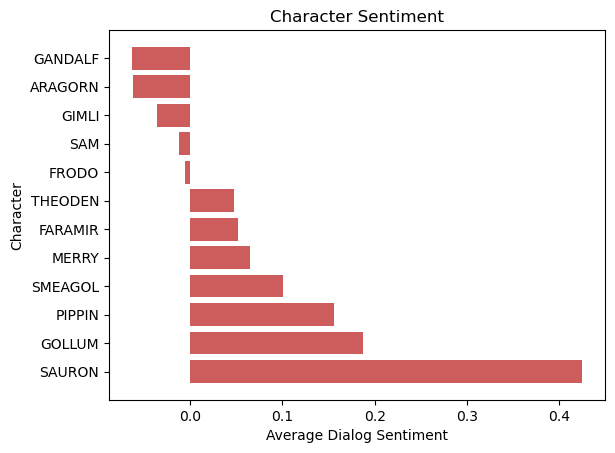

In [169]:
# # Plotting dialouge frequnecy
# char_sent = train.groupby("char")["dialog_sentiment"].mean().reset_index()
# char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
# plt.barh(char_sent.char[:10], char_sent.dialog_sentiment[:10], color="indianred")
# plt.title("Charcter sentiment")
# plt.show()

imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]
# Plotting dialouge frequnecy
char_sent = train.groupby("char")["dialog_sentiment"].mean().reset_index()
char_sent = char_sent.sort_values(by="dialog_sentiment", ascending=False)
char_sent_filtered = char_sent[char_sent['char'].isin(imp_char)]
plt.barh(char_sent_filtered['char'], char_sent_filtered['dialog_sentiment'], color="indianred")
plt.title("Character Sentiment")
plt.xlabel("Average Dialog Sentiment")
plt.ylabel("Character")
plt.show()

<h3> 4.3.1 LDA, topic detector </h3>

In [170]:
# Topic modelling using LDA

stemmer = SnowballStemmer("english")


def stem(text):
    return stemmer.stem(text)

def preprocess_for_topic(document: str) -> List[str]:

    #tokenized = nlp(document)

    preprocessed = []
    for token in gensim.utils.simple_preprocess(document, min_len=4):
        if token not in stopwords_set: #and len(token) > 3:
            preprocessed.append(stem(token.lower()))
    return preprocessed


def create_bow_corp(data):
    preprocessed = []
    [preprocessed.append(preprocess_for_topic(dialog)) for dialog in data.dialog]
    dic = corpora.Dictionary(preprocessed)
    bow_corpus = [dic.doc2bow(doc) for doc in preprocessed]
    return preprocessed, dic, bow_corpus

preprocessed_train, dic_train, bow_corpus_train = create_bow_corp(train)
preprocessed_test, dic_test, bow_corpus_test = create_bow_corp(test)


# lda_model = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 3, id2word = dic_train, passes = 10, workers = 2, random_state=42)
# lda_model.show_topics()

<h1> Delete the two cells below? </h2>

In [171]:
# # Extract top contributing words for each topic
# top_words_per_topic = []
# for topic_id in range(lda_model.num_topics):
#     topic_words = lda_model.show_topic(topic_id, topn=5)
#     top_words = [word for word, _ in topic_words]
#     top_words_per_topic.append(top_words)


# for i, words in enumerate(top_words_per_topic):
#     print(f"Topic {i}: {', '.join(words)}")

In [172]:
# # Classifying the dialogs to their respective topics
# predictions = lda_model[bow_corpus_train]
# topic_list = []

# for i, pred in enumerate(predictions[:5]):
#     max_prob_topic = max(pred, key=lambda x: x[1])
#     topic_list.append(max_prob_topic)
#     topic_num, prob = max_prob_topic
#     topic_keywords = ", ".join([word for word, _ in lda_model.show_topic(topic_num)])
#     print(f"Review {i}:")
#     print(f"Review body: {lotr_train.dialog[i]}")
#     print(f"Predicted Topic: {topic_num}, Confidence: {prob:.4f}")

In [173]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_train, dictionary=dic_train, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [174]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(bow_corpus_train)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus_train, int(num_of_docs*0.75)), 
               bow_corpus_train]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dic_train, 
                                                  k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)
                    
            pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 16/16 [04:11<00:00, 15.73s/it]


<h3> 4.3.2 Plot topics

In [175]:
model_res

,Validation_Set,Topics,Coherence
0,75% Corpus,3,0.397229
1,75% Corpus,4,0.403696
2,75% Corpus,5,0.433108
3,75% Corpus,6,0.443705
4,75% Corpus,7,0.485082
5,75% Corpus,8,0.459212
6,75% Corpus,9,0.512269
7,75% Corpus,10,0.471657
8,100% Corpus,3,0.432102
9,100% Corpus,4,0.468606


In [176]:
# Her må du plotte et diagram elns
model_res = pd.DataFrame(model_results)

lda_model_optimized = gensim.models.LdaMulticore(bow_corpus_train, num_topics = 3, id2word = dic_train, passes = 10, 
                                                 chunksize=100, random_state=42)

# Extract top contributing words for each topic
top_words_per_topic = []
for topic_id in range(lda_model_optimized.num_topics):
    topic_words = lda_model_optimized.show_topic(topic_id, topn=5)
    top_words = [word for word, _ in topic_words]
    top_words_per_topic.append(top_words)


for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: gondor, leav, king, good, fight
Topic 1: come, master, lord, take, would
Topic 2: frodo, gandalf, back, merri, ring


In [177]:

def topic_predictions(bow_data, data):
    predictions = lda_model_optimized[bow_data]
    data["topic"] = [max(pred, key=lambda x: x[1])[0] for pred in predictions]
    return data

lotr_train = topic_predictions(bow_corpus_train, train)
lotr_test = topic_predictions(bow_corpus_test, test)

In [178]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimized, bow_corpus_train, dictionary=lda_model_optimized.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.019406 -0.117301       1        1  34.719048
0     -0.100733  0.074110       2        1  32.663703
2      0.120139  0.043191       3        1  32.617250, topic_info=        Term       Freq      Total Category  logprob  loglift
8      frodo  78.000000  78.000000  Default  30.0000  30.0000
72      come  91.000000  91.000000  Default  29.0000  29.0000
23    master  33.000000  33.000000  Default  28.0000  28.0000
40     merri  25.000000  25.000000  Default  27.0000  27.0000
85   gandalf  36.000000  36.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
131     must  15.460360  47.109618   Topic3  -5.0202   0.0061
637     hold   9.427676  16.423178   Topic3  -5.5148   0.5653
264   hobbit  10.436489  30.744545   Topic3  -5.4131   0.0399
97     think   9.780393  25.580737   Topic3  -5.4781   0.1589
135     long   9.137388  25.493310   Topic3  -5.5461   0.0943

[212 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
870       1  0.946801    aagh
188       1  0.895330  across
794       2  0.931266   ahead
505       2  0.873193  almost
215       1  0.073581    alon
...     ...       ...     ...
741       2  0.878410   world
741       3  0.079855   world
106       1  0.484879   would
106       2  0.051040   would
106       3  0.459359   would

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

<h3> 4.4.1 In-depth snetiment analysis  </h3>

In [179]:
file_path = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' # path to downloaded lexicon file

def emotion_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion[word] = []
                lexicon_emotion[word].append(emotion) 
    return lexicon_emotion   

lexicon_emotion  = emotion_lexicon(file_path)

def emotion_counter(data):
    emotion_list = []

    for dialog in data.dialog:
        token_text = word_tokenize(dialog) # tokenize the text

        cleaned_text = [word for word in token_text if word not in stopwords_set] # remove stopwords
        emotion_counters = {emotion: 0 for emotions in lexicon_emotion.values() for emotion in emotions}
        for token in cleaned_text: # check every word in text
            if token in lexicon_emotion:
                token_emotions = lexicon_emotion[token]
                for emotion in token_emotions:
                    emotion_counters[emotion] += 1 # increase emotion values if the word in text is found in lexicon dictionary

        emotion_list.append(emotion_counters)
    emotions_df = pd.DataFrame(emotion_list)
    
    data = pd.concat([data, emotions_df], axis=1)
    return data, emotions_df

train, emotions_train_df = emotion_counter(train)
test, emotions_test_df = emotion_counter(test)

# emotions_df


In [180]:
# nan_count = lotr_train['dialog'].isna().sum()
# nan_count

In [182]:
# len(lotr_train)

In [183]:
char_emot = train.groupby('char')[['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise', 'positive', 
                                       'disgust', 'joy', 'anticipation']].sum().reset_index()
# char_emot

<h3> 4.4.2  Plot in-deth sentiment analysis

In [199]:
# char_emot

In [202]:

# char_emot_filtered = char_emot[char_emot['char'].isin(imp_char)]

# char_emot_filtered.plot(x='char', kind='bar', stacked=True,
#         title='Characters emotion')
# plt.show()

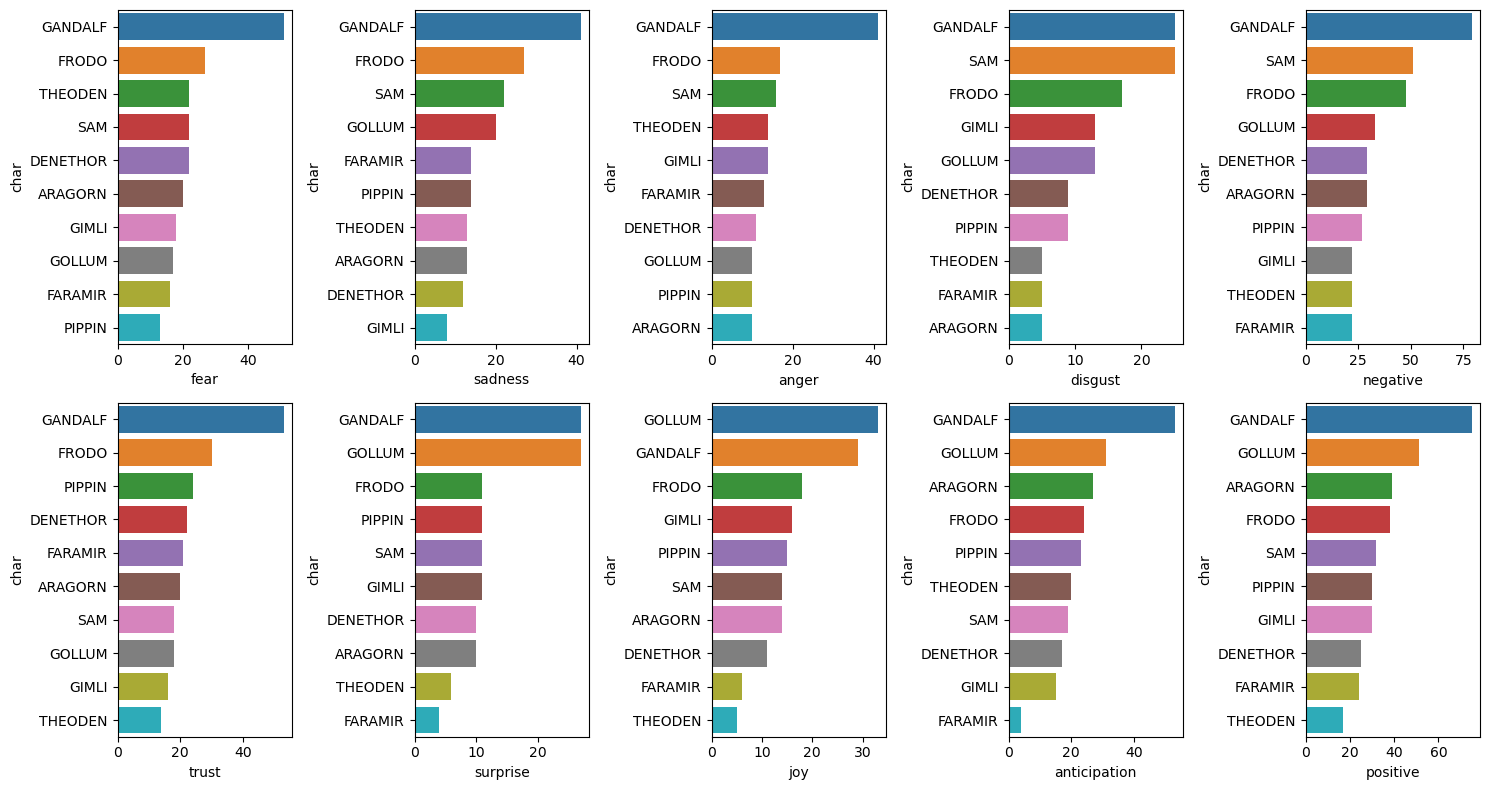

In [201]:
em_list = ['fear',  'sadness', 'anger', 'disgust', 'negative', 
           'trust', 'surprise',  'joy', 'anticipation', 'positive']

def char_emot_subplot(data, x):
    plt.figure(figsize = (15, 8))
    for i in range(1, len(x)+1):
        plt.subplot(2, 5, i)
        data = data.sort_values(by=x[i-1], ascending=False)[:10]
        sns.barplot(x=data[x[i-1]], y=data.char)
    plt.tight_layout()
    plt.show()

char_emot_subplot(char_emot, em_list)

<h3> 4.5.1 AVG TF-IDF Score for dialog

In [203]:
# nan_indices = lotr_train.dialog.isna()
# print(len(nan_indices))
# lotr_train

In [206]:
def tf(document: List[str], term: str) -> float:

    term_freq = FreqDist()
    for word in document:
        if word.lower() == term:
            term_freq[term] += 1
    
    termfreq = (term_freq[term])/len(document)
    return termfreq


def idf(documents: List[List[str]], term: str) -> float:

    doc_count = 0
    for doc in documents:
        if term in doc:
            doc_count +=1
    if doc_count == 0:
        return 0
    
    idf = np.log(len(documents)/(doc_count))
    return idf


def tf_idf(all_documents: List[List[str]], document: List[str], term: str) -> float:

    term_freq = tf(document, term)
    inverse_df = idf(all_documents, term)
    tf_idf = term_freq*inverse_df

    return tf_idf


def avg_tf_idf(data, preprocessed):
    dialog_avg_tfidf = []
    for dialog in preprocessed:
        score = 0
        for term in dialog:
            p = tf_idf(data.dialog, dialog, term)
            score += p
        avg_tfidf = score/(len(dialog)+1)
        dialog_avg_tfidf.append(avg_tfidf)
    data["avg_tf-idf"] = dialog_avg_tfidf
    return data

train = avg_tf_idf(train, preprocessed_train)
test = avg_tf_idf(test, preprocessed_test)
train.head()

,char,dialog,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,...,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,avg_tf-idf
0,ORCS,"Grond, Grond, Grond, Grond!",4,29,0,0,0,4,2,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
1,FRODO,Smeagol?,1,10,0,0,0,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000
2,SAM,Look!The gate.It's opening!I can see a way down.,8,49,2,1,0,0,8,0.125,...,0,0,0,0,0,0,0,0,0,1.286746
3,PIPPIN,"Well, that's good news.",4,24,0,0,1,0,4,0.500,...,0,0,0,0,1,1,0,1,1,1.231094
4,PIPPIN,Frodo.,1,11,0,0,0,1,1,0.000,...,0,0,0,0,0,0,0,0,0,0.000000


<h1> Saving datasets </h1>

In [207]:
train.to_csv('data/train_org.csv', index=False)
train.to_csv('data/test_org.csv', index=False)

In [208]:
train = pd.read_csv('data/train_org.csv')
test = pd.read_csv('data/test_org.csv')

imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "SAURON", "ARAGORN", "SMEAGOL"]

<h1> To soon 
## Character prediction
### Divide and conquer

In [231]:
# Creating a common label for the characters not of interest. 
# Aware that this will impact the model, unsure if it would be positive or negative


def common_label(data):
    mask = data["char"].isin(imp_char)
    data.loc[~ mask, "char"] = "Rest"
    mask2 = data['char'] == 'Rest'
    data = data[~mask2]
    return data

train = common_label(train)
test = common_label(test)


def x_y_split(data):
    y_data = data['char']
    x_data = data.drop(columns=['char', 'dialog'])
    return x_data, y_data

X_train, y_train = x_y_split(train)
X_test, y_test = x_y_split(test)

def char_2_num(y_data):
    encoder = LabelEncoder()
    y_data = y_data.values.reshape(-1, 1)
    encoded_data = encoder.fit_transform(y_data)
    names = list(encoder.inverse_transform(np.unique(encoded_data)))
    print(names)
    print(np.unique(encoded_data))
    return encoded_data, names

y_train, names = char_2_num(y_train)
y_test = char_2_num(y_test)[0]


['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'SAURON', 'SMEAGOL', 'THEODEN']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [234]:
y_test

array([2, 8, 7, ..., 3, 8, 0])

<h1> Modelling and evaluation </h1>
<h2> 1 Benchmarks <h2>

In [282]:
from sklearn.metrics import accuracy_score as ACC

<h2> 1.1 Monte Carlo for Naive Random Benchmark </h2>
<p> Running a Monte Carlo with 1000 simulations gives an approximate mean value of 8.3% in accuracy.

In [291]:
accuracy_list = []
for i in range(0,1000,1):
    naive_rand_pred = np.random.randint(0,12,size=(len(test)))
    accuracy_sel = ACC(naive_rand_pred, y_train)
    accuracy_list.append(accuracy_sel)

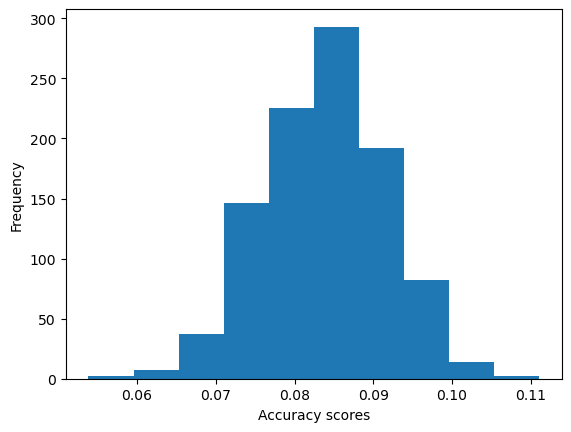

In [292]:
plt.figure()
plt.hist(accuracy_list)
plt.xlabel('Accuracy scores')
plt.ylabel('Frequency')
plt.show()

In [293]:
np.mean(accuracy_list)

0.08376736111111112

<h3> 1.2Majority Class Naive Benchmark </h3>

In [299]:
pred_MCNB =np.repeat(2,len(test))
ACC(pred_MCNB, y_test)

0.1449652777777778

### Random Forest Classifier


In [306]:
from sklearn.ensemble import RandomForestClassifier

In [314]:

rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [5,10,15],
    # 'min_samples_split': [ 5, 10, 15],
    #'min_samples_leaf': [1, 2, 3, 4],
    # 'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid,  cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

best_score = grid_search.best_score_
# print("Best Accuracy Score:", best_score)


# rfc(**grid_search.best_params_).fit(X_test, y_test)
# optimized = rfc(**grid_search.best_params_)
# optimized.fit(X, y)

# # Optimize parameters
# optimized_rf = optimize_model_parameters(X_train, y_train, RFC, param_grid)

TypeError: 'RandomForestClassifier' object is not callable

In [237]:
def evaluate_model(X, y, model):

    pred = model.predict(X)
    print(classification_report(y, pred))
    print("Accuracy ", round(accuracy_score(y, pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y, pred, average='weighted'), 4)) 
    return pred  

rfc_predictions = evaluate_model(X_train, y_train, optimized_rf) 

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       136
           1       0.95      0.39      0.56        51
           2       0.61      0.88      0.72       167
           3       0.68      0.77      0.72       138
           4       0.85      0.71      0.77        84
           5       0.74      0.69      0.71       102
           6       0.79      0.56      0.66       102
           7       0.66      0.72      0.69       119
           8       0.70      0.83      0.76       143
           9       0.00      0.00      0.00         5
          10       0.75      0.19      0.31        31
          11       0.95      0.55      0.70        74

    accuracy                           0.71      1152
   macro avg       0.70      0.59      0.61      1152
weighted avg       0.73      0.71      0.70      1152

Accuracy  0.7127
f1_score 0.7033
precision_score 0.7341
recall_score 0.7127


In [223]:
rfc_predictions

array([6, 8, 7, ..., 3, 8, 0])

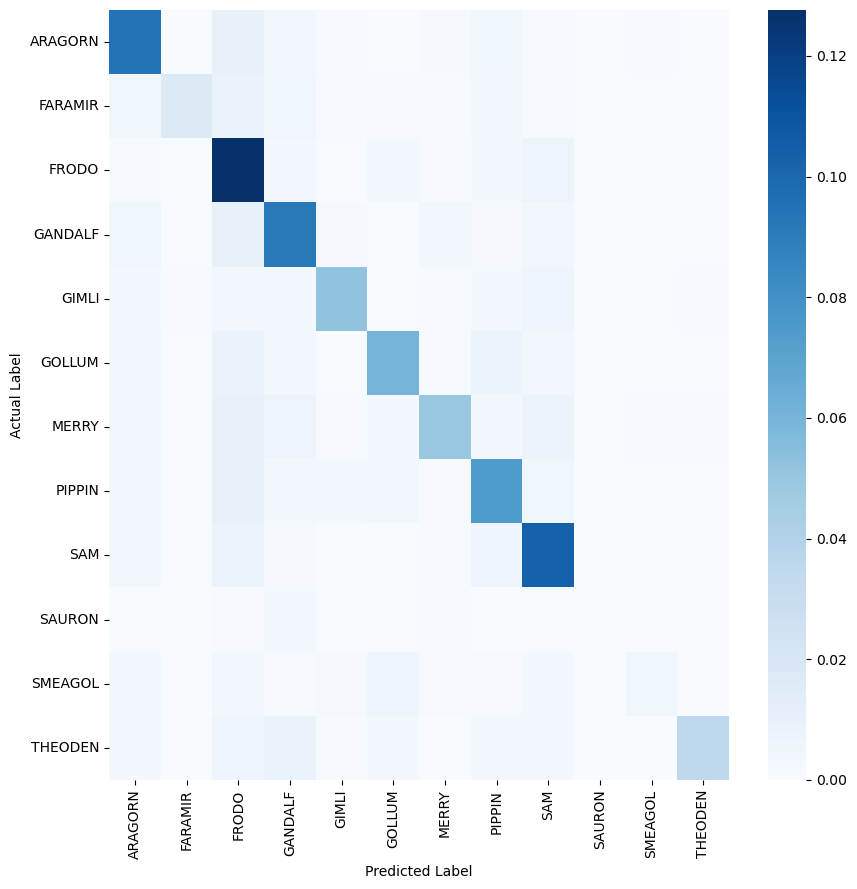

In [239]:

def conf_matrix(y, pred):
    cm = confusion_matrix(y, pred)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=False, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=names, yticklabels=names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

conf_matrix(y_test, rfc_predictions)

### ANN

In [240]:

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [247]:
X_train

,word_len,character_len,stopword_count,verb_count,adj_count,propn_count,uinque_words,dialog_sentiment,topic,trust,fear,negative,sadness,anger,surprise,positive,disgust,joy,anticipation,avg_tf-idf
1,1,10,0,0,0,0,1,0.000,2,0,0,0,0,0,0,0,0,0,0,0.000000
2,8,49,2,1,0,0,8,0.125,2,0,0,0,0,0,0,0,0,0,0,1.286746
3,4,24,0,0,1,0,4,0.500,2,1,0,0,0,0,1,1,0,1,1,1.231094
4,1,11,0,0,0,1,1,0.000,2,0,0,0,0,0,0,0,0,0,0,0.000000
5,13,72,4,1,0,4,13,-0.375,2,0,0,0,0,0,0,0,0,0,0,1.236963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,7,40,3,1,1,1,7,-0.375,1,0,1,1,0,1,0,0,1,0,0,1.284906
1664,7,37,4,2,0,0,6,0.375,1,0,0,0,0,0,0,0,0,0,0,3.364314
1665,8,66,3,0,2,1,8,-0.625,1,0,3,3,2,3,0,1,1,0,0,0.906740
1670,2,11,0,0,0,2,2,0.000,2,0,0,0,0,0,0,0,0,0,0,0.000000


In [257]:

x_val_ann, x_test_ann, y_val_ann,  y_test_ann = TTS(X_test_scaled, y_test, random_state=42, test_size=0.5)
y_train_eye = np.eye(12)[y_train]
y_val_eye = np.eye(12)[y_test_ann]
y_test_eye = np.eye(12)[y_val_ann] 

In [264]:
y_train_eye.shape

(1152, 12)

In [266]:

def neural_net(x_train, y_train, x_val, y_val):
    classifier = Sequential()

    classifier.add(Dense(units=40, activation = 'relu', input_dim = 20))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units=40, activation = 'selu'))
    classifier.add(Dropout(0.3))

    classifier.add(Dense(units=40, activation = 'relu'))
    classifier.add(Dense(units=40, activation = 'gelu'))
    classifier.add(Dense(units=12, activation='softmax'))
    classifier.add(Dense(12))

    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print(classifier.summary())

    classifier.fit(x_train, y_train, epochs=250,  
                        batch_size=10, #callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001)],
                        validation_data=(x_val, y_val), verbose=1)
    return classifier
    
optimized_ann = neural_net(X_train_scaled, y_train_eye, x_val_ann, y_val_eye)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 12)             │           492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,568 (25.66 KB)

 Trainable params: 6,488 (25.34 KB)

 Non-trainable params: 80 (320.00 B)

None
Epoch 1/250


116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0909 - loss: 7.9786 - val_accuracy: 0.0955 - val_loss: 7.0598
Epoch 2/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0831 - loss: 8.0187 - val_accuracy: 0.0955 - val_loss: 7.4071
Epoch 3/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0871 - loss: 7.6589 - val_accuracy: 0.1007 - val_loss: 7.8840
Epoch 4/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0783 - loss: 8.1065 - val_accuracy: 0.0885 - val_loss: 7.6691
Epoch 5/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0949 - loss: 8.2326 - val_accuracy: 0.0920 - val_loss: 7.5444
Epoch 6/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0746 - loss: 8.2729 - val_accuracy: 0.0920 - val_loss: 7.7400
Epoch 7/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0868 - loss: 7.8448 - val_accuracy: 0.0885 - val_loss: 8.3492
Epoch 8/250
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0854 - loss: 8.2639 - val_accuracy: 0.0885

In [272]:
def evaluate_ann(X, y, model):

    pred_matrix = model.predict(X)
    ann_prediction = np.argmax(pred_matrix, axis=1)
    print(classification_report(y, ann_prediction))
    print("Accuracy ", round(accuracy_score(y, ann_prediction), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(y, ann_prediction, average='weighted'), 4)) 
    return ann_prediction  


ann_prediction = evaluate_ann(x_test_ann, y_test_eye, optimized_ann)
# conf_matrix(y_test_eye, ann_prediction)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets